## Backtesting Crypto Strategies to be implemented in GoLang

### Environment:

Data Loader: Gets OHLCV data (you can use yfinance, ccxt, or CSVs)

Signal Generator (Strategy): Returns a DataFrame of portfolio weights

Backtester: Calculates portfolio value over time

Evaluator: Computes metrics like Sharpe ratio, drawdown, turnover

Visualizer: Plots equity curve and stats

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ccxt
import time


## Data Loader:

In [2]:

def fetch_full_hourly_ohlcv(symbol, start_date='2023-01-01T00:00:00Z'):
    exchange = ccxt.binance()
    market = symbol + '/USDT'
    timeframe = '1h'
    limit = 1000
    all_data = []

    # Converts the human-readable date to a millisecond timestamp.
    since = exchange.parse8601(pd.to_datetime(start_date).isoformat())
 

    while True:
        print(f"Fetching {symbol} since {pd.to_datetime(since, unit='ms')}")
        data = exchange.fetch_ohlcv(market, timeframe=timeframe, since=since, limit=limit)
        if not data:
            break
        all_data.extend(data)
        since = data[-1][0] + 1  # Move past the last fetched timestamp
        time.sleep(1.2)  # Respect Binance rate limits

        # Optional: stop once we're beyond current time
        if pd.to_datetime(data[-1][0], unit='ms') >= pd.Timestamp.now():
            break

    df = pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('date', inplace=True)
    return df[['close']]

def load_hourly_prices(symbols, start_date='2023-01-01T00:00:00Z'):
    all_data = []
    for symbol in symbols:
        try:
            print(f"\nLoading {symbol}...")
            df = fetch_full_hourly_ohlcv(symbol, start_date)
            df.rename(columns={'close': symbol}, inplace=True)
            all_data.append(df)
        except Exception as e:
            print(f"Failed to fetch {symbol}: {e}")
        time.sleep(1.5)
    
    price_df = pd.concat(all_data, axis=1).ffill().dropna()
    price_df.to_csv("hourly_crypto_prices.csv")
    print("\nSaved to hourly_crypto_prices.csv ✅")
    return price_df


In [4]:
# Fetch data and save to CSV
symbols = ['BTC', 'ETH', 'SOL', 'BNB', 'XRP']
prices = load_hourly_prices(symbols, start_date='2023-05-01T00:00:00Z')
prices.head()


Loading BTC...
Fetching BTC since 2023-05-01 00:00:00
Fetching BTC since 2023-06-11 15:00:00.001000
Fetching BTC since 2023-07-23 07:00:00.001000
Fetching BTC since 2023-09-02 23:00:00.001000
Fetching BTC since 2023-10-14 15:00:00.001000
Fetching BTC since 2023-11-25 07:00:00.001000
Fetching BTC since 2024-01-05 23:00:00.001000
Fetching BTC since 2024-02-16 15:00:00.001000
Fetching BTC since 2024-03-29 07:00:00.001000
Fetching BTC since 2024-05-09 23:00:00.001000
Fetching BTC since 2024-06-20 15:00:00.001000
Fetching BTC since 2024-08-01 07:00:00.001000
Fetching BTC since 2024-09-11 23:00:00.001000
Fetching BTC since 2024-10-23 15:00:00.001000
Fetching BTC since 2024-12-04 07:00:00.001000
Fetching BTC since 2025-01-14 23:00:00.001000
Fetching BTC since 2025-02-25 15:00:00.001000
Fetching BTC since 2025-04-08 07:00:00.001000
Fetching BTC since 2025-05-19 23:00:00.001000
Fetching BTC since 2025-05-27 08:00:00.001000

Loading ETH...
Fetching ETH since 2023-05-01 00:00:00
Fetching ETH sin

,BTC,ETH,SOL,BNB,XRP
date,,,,,
2023-05-01 00:00:00,29315.57,1885.33,22.84,338.8,0.4711
2023-05-01 01:00:00,28504.36,1836.00,22.19,333.4,0.4633
2023-05-01 02:00:00,28549.41,1843.87,22.20,333.7,0.4606
2023-05-01 03:00:00,28561.06,1846.58,22.18,334.5,0.4648
2023-05-01 04:00:00,28555.00,1847.67,22.17,334.5,0.4653


## Signal Generation:

In [3]:
# Equal Weight Strategy:
def equal_weight_strategy(prices: pd.DataFrame) -> pd.DataFrame:
    """
    Generate an equal-weighted signal for all available tokens at each timestamp.
    
    Parameters:
        prices : DF of token prices with datetime index and token symbols as columns.
    
    Returns:
        DF: Equal-weight portfolio weights over time.
    """
    
    num_assets = prices.shape[1]
    equal_weights = pd.DataFrame(
        1 / num_assets,
        index=prices.index,
        columns=prices.columns
    )
    return equal_weights

In [13]:
# Implement equal weight strategy:
prices_ew = pd.read_csv("hourly_crypto_prices.csv", index_col=0, parse_dates=True)

weights_ew = equal_weight_strategy(prices_ew)
weights_ew.head() 


,BTC,ETH,SOL,BNB,XRP
date,,,,,
2023-05-01 00:00:00,0.2,0.2,0.2,0.2,0.2
2023-05-01 01:00:00,0.2,0.2,0.2,0.2,0.2
2023-05-01 02:00:00,0.2,0.2,0.2,0.2,0.2
2023-05-01 03:00:00,0.2,0.2,0.2,0.2,0.2
2023-05-01 04:00:00,0.2,0.2,0.2,0.2,0.2


## Backtest

In [19]:
# Backtest:

def compute_log_returns(prices: pd.DataFrame) -> pd.DataFrame:
    return np.log(prices / prices.shift(1)).fillna(0)

def backtest_portfolio(prices: pd.DataFrame, weights: pd.DataFrame, transaction_fee: float = 0.0):
    """
    Backtest any portfolio weight strategy with optional transaction costs.

    Parameters:
        prices (pd.DataFrame): Price data (Date x Assets).
        weights (pd.DataFrame): Portfolio weights (Date x Assets).
        transaction_fee (float): Cost per unit traded (e.g., 0.001 = 0.10%).

    Returns:
        portfolio_log_returns (pd.Series): Strategy log returns (after cost).
        cumulative_returns (pd.Series): Cumulative portfolio value over time.
        turnover_series (pd.Series): Portfolio turnover at each step.
    """
    log_returns = compute_log_returns(prices)
    shifted_weights = weights.shift(1).fillna(0)

    # Calculate raw log returns from portfolio
    raw_log_returns = (shifted_weights * log_returns).sum(axis=1)

    # Compute turnover (sum of absolute changes in weights)
    turnover = (weights - shifted_weights).abs().sum(axis=1)

    # Compute cost = turnover × transaction_fee
    cost = turnover * transaction_fee

    # Subtract transaction cost from log returns
    net_log_returns = raw_log_returns - cost

    cumulative_returns = np.exp(net_log_returns.cumsum())
    return net_log_returns, cumulative_returns, turnover



## Evaluate:

In [20]:
def evaluate_performance(portfolio_log_returns: pd.Series):
    mean_ret = portfolio_log_returns.mean()
    std_ret = portfolio_log_returns.std()
    
    # Annualized Sharpe for hourly returns (~8760 trading hours/year)
    sharpe_ratio = (mean_ret / std_ret) * np.sqrt(8760)

    cumulative_returns = np.exp(portfolio_log_returns.cumsum())
    running_max = cumulative_returns.cummax()
    drawdown = 1 - (cumulative_returns / running_max)

    max_dd = drawdown.max()
    end_date = drawdown.idxmax()
    start_date = cumulative_returns[:end_date].idxmax()

    return {
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_dd,
        "Max Drawdown Start": start_date,
        "Max Drawdown End": end_date,
        "Total Return": cumulative_returns.iloc[-1] - 1
    }


def plot_equity_curve(cumulative_returns):
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="Equal-Weighted Portfolio")
    plt.title("Equity Curve")
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.legend()
    plt.show()

In [32]:
# Evaluate metrics:

portfolio_log_returns_ew, cumulative_returns_ew, turnover_ew = backtest_portfolio(prices_ew, weights_ew, transaction_fee=0.000)
metrics = evaluate_performance(portfolio_log_returns_ew)

print("Performance Metrics:")
for k, v in metrics.items():
    if isinstance(v, (int, float)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")



Performance Metrics:
Sharpe Ratio: 0.9752
Max Drawdown: 0.4755
Max Drawdown Start: 2025-01-20 08:00:00
Max Drawdown End: 2025-04-07 06:00:00
Total Return: 2.3108


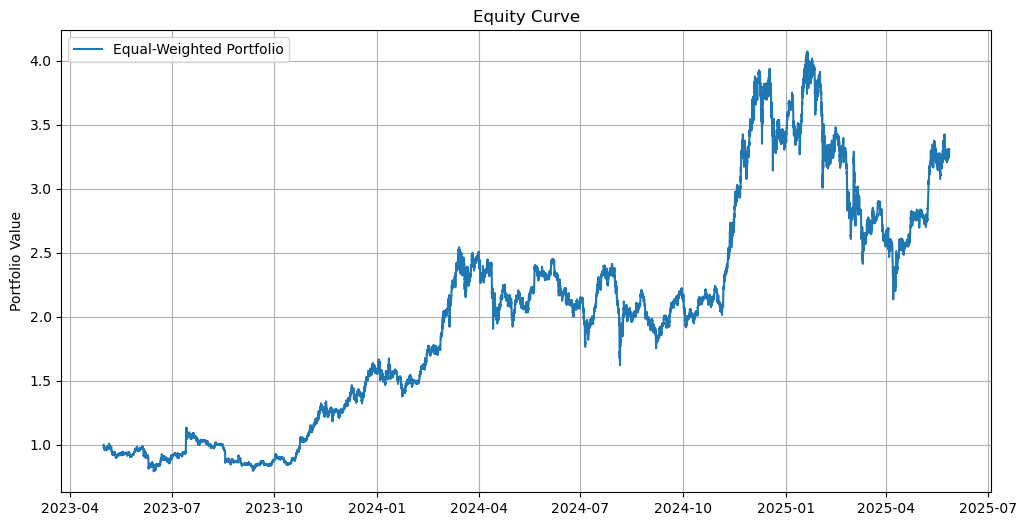

In [33]:
# Visualization

plot_equity_curve(cumulative_returns_ew)
